# T-SNE - Rapids

* NVIDIA created [RAPIDS](https://rapids.ai/) – an open-source data analytics and machine learning acceleration platform that leverages GPUs to accelerate computations. RAPIDS is based on Python, has Pandas-like and Scikit-Learn-like interfaces, is built on Apache Arrow in-memory data format, and can scale from 1 to multi-GPU to multi-nodes. RAPIDS integrates easily into the world’s most popular data science Python-based workflows. RAPIDS accelerates data science end-to-end – from data prep, to machine learning, to deep learning

In [1]:
%%capture
import sys
!cp ../input/rapids/rapids.0.15.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [2]:
import cudf, cuml
import pandas as pd
import numpy as np
from cuml.manifold import TSNE
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load data

In [3]:
data_dir = '/kaggle/input/stanford-covid-vaccine/'
train = pd.read_json(data_dir + 'train.json', lines=True)
test = pd.read_json(data_dir + 'test.json', lines=True)
sample_df = pd.read_csv(data_dir + 'sample_submission.csv')

public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [4]:
# Train
train_dict = {}
for col in ['sequence','structure','predicted_loop_type']:
        for sentence in train[col].iteritems():
            char_list = list(sentence[1])
            for i,c in enumerate(char_list):
                if f"{col}_{str(i)}" in train_dict:
                    train_dict[f"{col}_{str(i)}"].append(c)
                else:
                    train_dict[f"{col}_{str(i)}"] = [c]
                    
# public_df   
public_dict = {}
for col in ['sequence','structure','predicted_loop_type']:
        for sentence in public_df[col].iteritems():
            char_list = list(sentence[1])
            for i,c in enumerate(char_list):
                if f"{col}_{str(i)}" in public_dict:
                    public_dict[f"{col}_{str(i)}"].append(c)
                else:
                    public_dict[f"{col}_{str(i)}"] = [c]
                    
# private_df  
private_dict = {}
for col in ['sequence','structure','predicted_loop_type']:
        for sentence in private_df[col].iteritems():
            char_list = list(sentence[1])
            for i,c in enumerate(char_list):
                if f"{col}_{str(i)}" in private_dict:
                    private_dict[f"{col}_{str(i)}"].append(c)
                else:
                    private_dict[f"{col}_{str(i)}"] = [c]

In [5]:
train_df = pd.DataFrame(train_dict)
train_df.head()

,sequence_0,sequence_1,sequence_2,sequence_3,sequence_4,sequence_5,sequence_6,sequence_7,sequence_8,sequence_9,...,predicted_loop_type_97,predicted_loop_type_98,predicted_loop_type_99,predicted_loop_type_100,predicted_loop_type_101,predicted_loop_type_102,predicted_loop_type_103,predicted_loop_type_104,predicted_loop_type_105,predicted_loop_type_106
0,G,G,A,A,A,A,G,C,U,C,...,E,E,E,E,E,E,E,E,E,E
1,G,G,A,A,A,A,A,G,C,G,...,E,E,E,E,E,E,E,E,E,E
2,G,G,A,A,A,G,U,G,C,U,...,E,E,E,E,E,E,E,E,E,E
3,G,G,A,A,A,A,G,C,G,C,...,E,E,E,E,E,E,E,E,E,E
4,G,G,A,A,A,A,U,A,U,A,...,E,E,E,E,E,E,E,E,E,E


### OHE OF data

In [6]:
train_df_one_hot = pd.get_dummies(train_df)
for col,chars in zip(['sequence','structure','predicted_loop_type'],[['G','A', 'C', 'U'],['.', '(', ')'],['E', 'S', 'H', 'B', 'X','I','M']]):
    print(col,chars)
    for i in range(107):
        for char in chars:
            if f"{col}_{i}_{char}" not in train_df_one_hot.columns:
                train_df_one_hot[f"{col}_{i}_{char}"] = 0
#                 print("Column",f"{col}_{i}_{char}", "Added")
train_df_one_hot.head()

sequence ['G', 'A', 'C', 'U']
structure ['.', '(', ')']
predicted_loop_type ['E', 'S', 'H', 'B', 'X', 'I', 'M']


,sequence_0_G,sequence_1_G,sequence_2_A,sequence_3_A,sequence_4_A,sequence_5_A,sequence_5_C,sequence_5_G,sequence_5_U,sequence_6_A,...,predicted_loop_type_105_B,predicted_loop_type_105_X,predicted_loop_type_105_I,predicted_loop_type_105_M,predicted_loop_type_106_S,predicted_loop_type_106_H,predicted_loop_type_106_B,predicted_loop_type_106_X,predicted_loop_type_106_I,predicted_loop_type_106_M
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
select_features = []
public_df = pd.DataFrame(public_dict)
public_df_one_hot = pd.get_dummies(public_df)
for col,chars in zip(['sequence','structure','predicted_loop_type'],[['G','A', 'C', 'U'],['.', '(', ')'],['E', 'S', 'H', 'B', 'X','I','M']]):
    for i in range(107):
        for char in chars:
            select_features.append(f"{col}_{i}_{char}")
            if f"{col}_{i}_{char}" not in public_df_one_hot.columns:
                public_df_one_hot[f"{col}_{i}_{char}"] = 0
#                 print("Column",f"{col}_{i}_{char}", "Added")
public_df_one_hot.head()

,sequence_0_G,sequence_1_G,sequence_2_A,sequence_3_A,sequence_4_A,sequence_5_A,sequence_5_C,sequence_5_G,sequence_5_U,sequence_6_A,...,predicted_loop_type_105_B,predicted_loop_type_105_X,predicted_loop_type_105_I,predicted_loop_type_105_M,predicted_loop_type_106_S,predicted_loop_type_106_H,predicted_loop_type_106_B,predicted_loop_type_106_X,predicted_loop_type_106_I,predicted_loop_type_106_M
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
private_df = pd.DataFrame(private_dict)
private_df_one_hot = pd.get_dummies(private_df)
for col,chars in zip(['sequence','structure','predicted_loop_type'],[['G','A', 'C', 'U'],['.', '(', ')'],['E', 'S', 'H', 'B', 'X','I','M']]):
    for i in range(130):
        for char in chars:
            if f"{col}_{i}_{char}" not in private_df_one_hot.columns:
                private_df_one_hot[f"{col}_{i}_{char}"] = 0
#                 print("Column",f"{col}_{i}_{char}", "Added")
private_df_one_hot.head()

,sequence_0_G,sequence_1_G,sequence_2_A,sequence_3_A,sequence_4_A,sequence_5_A,sequence_5_C,sequence_5_G,sequence_5_U,sequence_6_A,...,predicted_loop_type_128_B,predicted_loop_type_128_X,predicted_loop_type_128_I,predicted_loop_type_128_M,predicted_loop_type_129_S,predicted_loop_type_129_H,predicted_loop_type_129_B,predicted_loop_type_129_X,predicted_loop_type_129_I,predicted_loop_type_129_M
0,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print("Train Features Shape : ",train_df_one_hot.shape)
print("Public Features Shape : ",public_df_one_hot.shape)
print("private Features Shape : ",private_df_one_hot.shape)

Train Features Shape :  (2400, 1498)
Public Features Shape :  (629, 1498)
private Features Shape :  (3005, 1820)


### Method for get TSNE 2D axis

In [10]:
def get_tsne(X):
    X_reshape = X.reshape(len(X),-1)
    tsne = TSNE(n_components=2 ,init='pca', n_iter=2500, random_state=23)
    X_reshape_2D = tsne.fit_transform(X_reshape)
    return X_reshape_2D

## Plot TSNE

###  Individual data

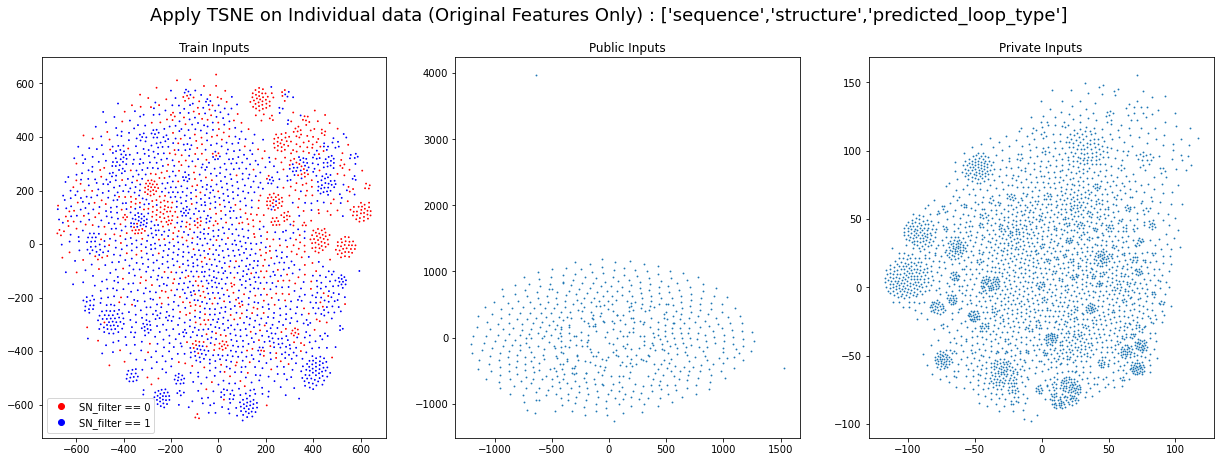

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,7))
fig.suptitle("Apply TSNE on Individual data (Original Features Only) : ['sequence','structure','predicted_loop_type']", fontsize=18)

train_2D = get_tsne(train_df_one_hot[select_features].values)
train_SN_filter = train_SN_filter = train['SN_filter'].values
classes = ['SN_filter == 0', 'SN_filter == 1']
colours = ListedColormap(['r','b'])
ax1.set(title="Train Inputs")
scatter = ax1.scatter(train_2D[:,0], train_2D[:,1],c=train_SN_filter,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

public_2D = get_tsne(public_df_one_hot[select_features].values)
scatter = ax2.scatter(public_2D[:,0], public_2D[:,1],s = 0.7)
ax2.set(title="Public Inputs")

private_2D = get_tsne(private_df_one_hot.values)
scatter = ax3.scatter(private_2D[:,0], private_2D[:,1],s = 0.7)
ax3.set(title="Private Inputs")

plt.savefig('0.png')
plt.show()

### Train + Public

Train Features Shape :  (2400, 1498)
Public Features Shape :  (629, 1498)
test_public Shape:  (3029, 1498)


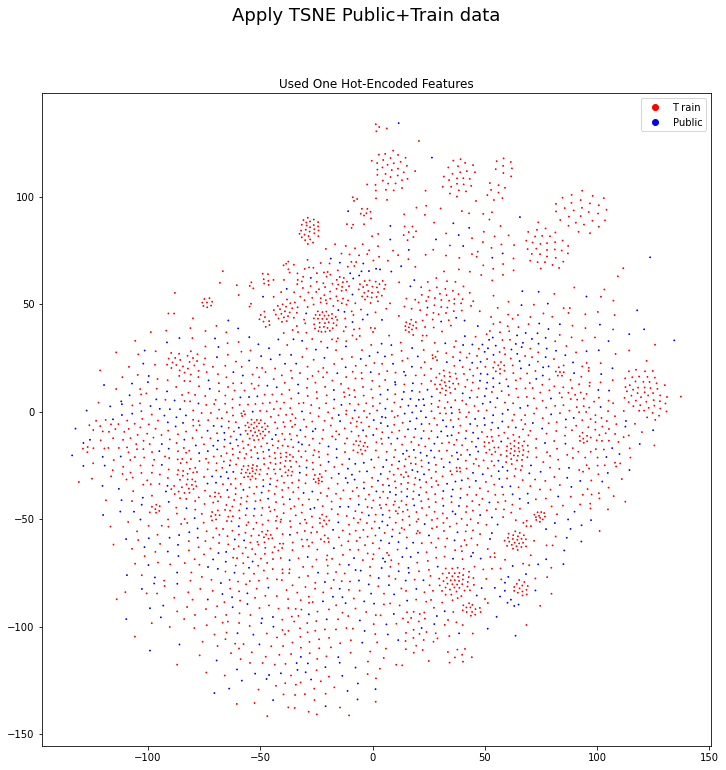

In [12]:
test_public = np.vstack([train_df_one_hot[select_features].values, public_df_one_hot[select_features].values])
print("Train Features Shape : ",train_df_one_hot.shape)
print("Public Features Shape : ",public_df_one_hot.shape)
print("test_public Shape: ",test_public.shape)

test_public_2D = get_tsne(test_public)
test_public_y = [0]*len(train_df_one_hot) + [1]*len(public_df_one_hot) 
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
fig.suptitle("Apply TSNE Public+Train data", fontsize=18)
classes = ['T rain', 'Public']
colours = ListedColormap(['r','b'])
ax1.set(title="Used One Hot-Encoded Features")
scatter = ax1.scatter(test_public_2D[:,0], test_public_2D[:,1],c=test_public_y,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('1.png')
plt.show()

### All data

Train Features Shape :  (2400, 1498)
Public Features Shape :  (629, 1498)
private Features Shape :  (3005, 1820)
X_all Shape:  (6034, 1498)


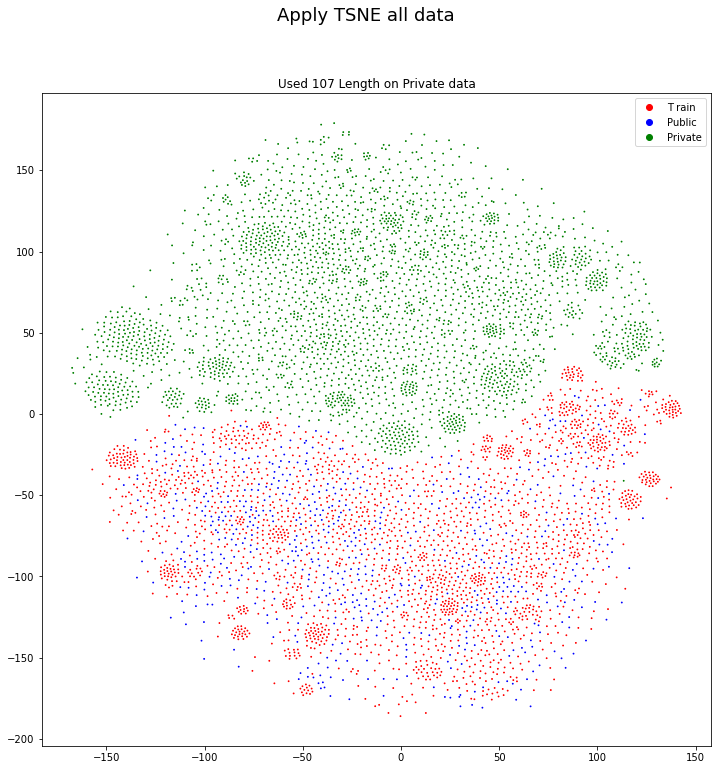

In [13]:
X_all = np.vstack([train_df_one_hot[select_features].values, public_df_one_hot[select_features].values,private_df_one_hot[select_features].values])
print("Train Features Shape : ",train_df_one_hot.shape)
print("Public Features Shape : ",public_df_one_hot.shape)
print("private Features Shape : ",private_df_one_hot.shape)
print("X_all Shape: ",X_all.shape)

X_all_2D = get_tsne(X_all)
X_all_y = [0]*len(train_df_one_hot) + [1]*len(public_df_one_hot) + [2]*len(private_df_one_hot)
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
fig.suptitle("Apply TSNE all data", fontsize=18)
classes = ['T rain', 'Public', 'Private']
colours = ListedColormap(['r','b','g'])
ax1.set(title="Used 107 Length on Private data")
scatter = ax1.scatter(X_all_2D[:,0], X_all_2D[:,1],c=X_all_y,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('2.png')
plt.show()

### BPPS Data

In [14]:
## https://www.kaggle.com/its7171/dangerous-features
public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").max(axis=1))
    return bpps_arr

def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").sum(axis=1))
    return bpps_arr

def read_bpps_nb(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_arr.append(bpps_nb)
    return bpps_arr 

train['bpps_max'] = read_bpps_max(train)
public_df['bpps_max'] = read_bpps_max(public_df)
private_df['bpps_max'] = read_bpps_max(private_df)

train['bpps_sum'] = read_bpps_sum(train)
public_df['bpps_sum'] = read_bpps_sum(public_df)
private_df['bpps_sum'] = read_bpps_sum(private_df)

train['bpps_nb'] = read_bpps_nb(train)
public_df['bpps_nb'] = read_bpps_nb(public_df)
private_df['bpps_nb'] = read_bpps_nb(private_df)

train_bpps = np.transpose( np.array(train[['bpps_max','bpps_sum','bpps_nb']].values.tolist()),(0, 2, 1))
public_bpps = np.transpose( np.array(public_df[['bpps_max','bpps_sum','bpps_nb']].values.tolist()),(0, 2, 1))
private_bpps = np.transpose( np.array(private_df[['bpps_max','bpps_sum','bpps_nb']].values.tolist()),(0, 2, 1))

print("train_bpps Shape : ",train_bpps.shape)
print("public_bpps Shape : ",public_bpps.shape)
print("private_bpps Shape : ",private_bpps.shape)

train_bpps Shape :  (2400, 107, 3)
public_bpps Shape :  (629, 107, 3)
private_bpps Shape :  (3005, 130, 3)


train_public_private_bpps_max Shape :  (6034, 107)
train_public_private_bpps_sum Shape :  (6034, 107)
train_public_private_bpps_nb Shape :  (6034, 107)


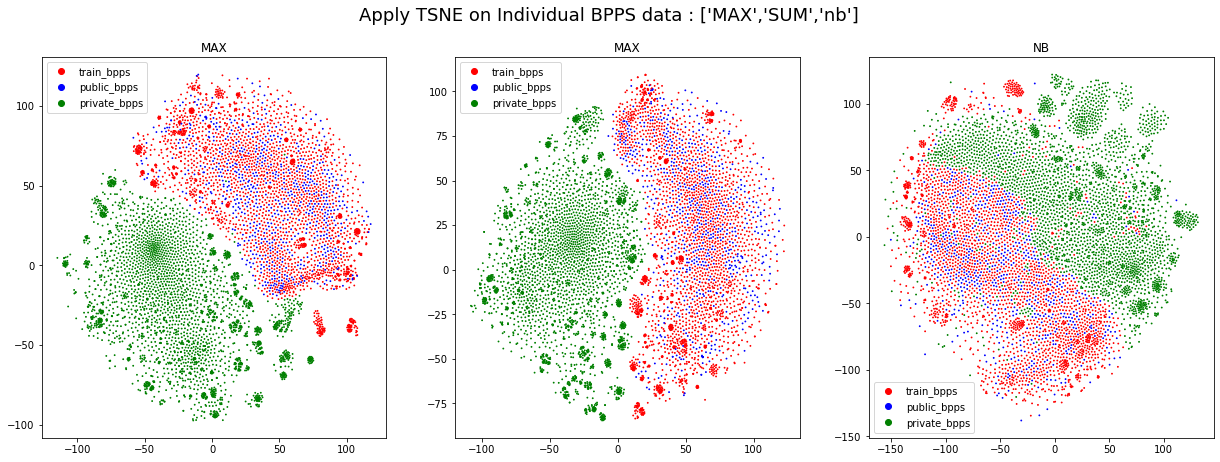

In [15]:
### BPPS Feaures TSNE on individual columns

train_public_private_bpps_max = np.vstack([train_bpps[:,:,0], public_bpps[:,:,0],private_bpps[:,:107,0]])
train_public_private_bpps_sum = np.vstack([train_bpps[:,:,1], public_bpps[:,:,1],private_bpps[:,:107,1]])
train_public_private_bpps_nb = np.vstack([train_bpps[:,:,2], public_bpps[:,:,2],private_bpps[:,:107,2]])

print("train_public_private_bpps_max Shape : ",train_public_private_bpps_max.shape)
print("train_public_private_bpps_sum Shape : ",train_public_private_bpps_sum.shape)
print("train_public_private_bpps_nb Shape : ",train_public_private_bpps_nb.shape)

yy = [0]*len(train_bpps) + [1]*len(public_bpps) + [2]*len(private_bpps)

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,7))
fig.suptitle("Apply TSNE on Individual BPPS data : ['MAX','SUM','nb']", fontsize=18)

train_public_private_bpps_max_2D = get_tsne(train_public_private_bpps_max)
classes = ['train_bpps','public_bpps','private_bpps']
colours = ListedColormap(['r','b','g'])
ax1.set(title="MAX")
scatter = ax1.scatter(train_public_private_bpps_max_2D[:,0], train_public_private_bpps_max_2D[:,1],c=yy,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

train_public_private_bpps_sum_2D = get_tsne(train_public_private_bpps_sum)
classes = ['train_bpps','public_bpps','private_bpps']
colours = ListedColormap(['r','b','g'])
ax2.set(title="MAX")
scatter = ax2.scatter(train_public_private_bpps_sum_2D[:,0], train_public_private_bpps_sum_2D[:,1],c=yy,cmap=colours,s = 0.7)
ax2.legend(handles=scatter.legend_elements()[0], labels=classes)

train_public_private_bpps_nb_2D = get_tsne(train_public_private_bpps_nb)
classes = ['train_bpps','public_bpps','private_bpps']
colours = ListedColormap(['r','b','g'])
ax3.set(title="NB")
scatter = ax3.scatter(train_public_private_bpps_nb_2D[:,0], train_public_private_bpps_nb_2D[:,1],c=yy,cmap=colours,s = 0.7)
ax3.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('3.png')
plt.show()

train_public_private_input shape :  (6034, 107, 3)


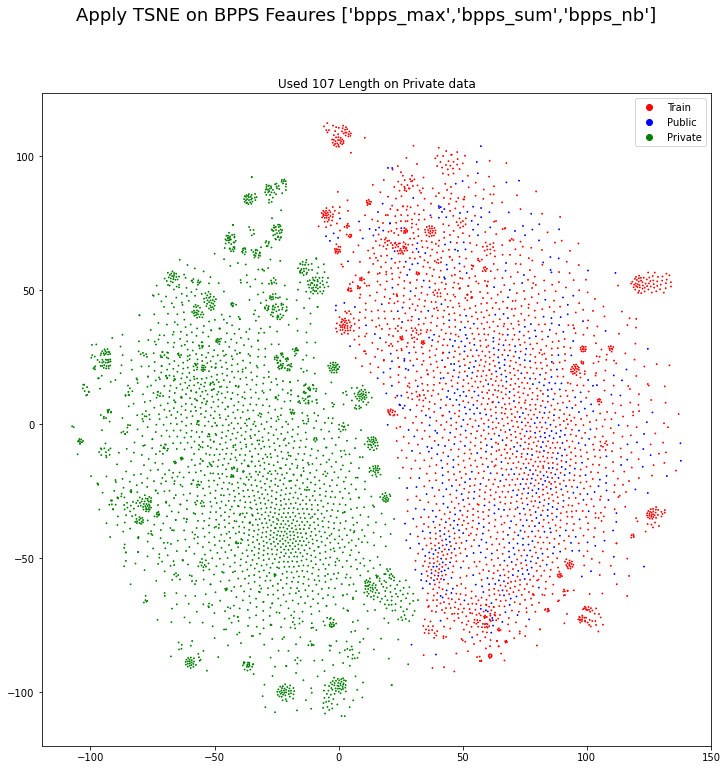

In [16]:
### BPPS Feaures TSNE

train_public_private_bpps = np.vstack([train_bpps, public_bpps,private_bpps[:,:107,:]])
train_public_private_bpps_2D = get_tsne(train_public_private_bpps)
train_public_private_bpps_y = [0]*len(train_bpps)+[1]*len(public_bpps)+[2]*len(private_bpps)

print("train_public_private_input shape : ",train_public_private_bpps.shape)

fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
fig.suptitle("Apply TSNE on BPPS Feaures ['bpps_max','bpps_sum','bpps_nb']", fontsize=18)
classes = ['Train', 'Public', 'Private']
colours = ListedColormap(['r','b','g'])
ax1.set(title="Used 107 Length on Private data")
scatter = ax1.scatter(train_public_private_bpps_2D[:,0], train_public_private_bpps_2D[:,1],c=train_public_private_bpps_y,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('4.png')
plt.show()